In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import lasio
import os
import pandas as pd
path_to_RIGIS = r'./welldata/RIGIS/'
path_to_GIS = r'./welldata/GIS_md/'
path_to_welltracks = r'./welldata/welltracks.txt'
lasFileNames = []

def getLasDataFrames(path = path_to_RIGIS):
    lasDF = []
    for file in os.listdir(path):
        if file.endswith('.las'):
            lasFileNames.append(file[:-4])
            lasDF.append(lasio.read(path+file).df())
    return lasDF

lasDataFrame = getLasDataFrames()

In [2]:
len(lasDataFrame)

72

In [3]:
def parse_welltracks():
    welltracks = []
    f = open(path_to_welltracks)
    welldata = f.read().split(';')
    for well in welldata:
        if len(well.split()) > 2:
            name = well.split()[2][:-1]
            data = well.split()[3:]
            x = [float(data[i]) for i in range(len(data)) if i % 4 == 0]
            y = [float(data[i]) for i in range(len(data)) if i % 4 == 1]
            tvdss = [float(data[i]) for i in range(len(data)) if i % 4 == 2]
            md = [float(data[i]) for i in range(len(data)) if i % 4 == 3]
            if(lasFileNames.count(name) > 0):
                welltracks.append([name, x, y ,tvdss, md]) # в таком виде хранятся
            else:
                print(name)

    return welltracks


In [4]:
from scipy.interpolate import interp1d
import math
def get_heights_list():
    welltracks = parse_welltracks()
    tvdconv = []
    for tracknum in range(len(welltracks)):
        f = interp1d(welltracks[tracknum][4], welltracks[tracknum][3])
        tvdconv.append(f)

    heights = []
    print(len(lasDataFrame))
    for k  in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        tmp_sum = 0
        for i in range(len(frame['KG_T']) - 1):
            if (frame['KG_T'].array[i + 1] >= 0):
                tmp_sum += tvdconv[k](frame['KG_T'].index[i + 1]) - tvdconv[k](frame['KG_T'].index[i])
        heights.append(tmp_sum)
    return heights
get_heights_list()

20-1
30-1
48-1
54-1
68-1
73-1
72


[11.278141480000045,
 0,
 0,
 3.7000000000000455,
 22.59999999999991,
 26.70000000000016,
 34.49963349999996,
 25.3959541600002,
 32.09999999999991,
 23.09999999999991,
 21.788350800000103,
 6.299763800000051,
 24.099999999999795,
 26.393493599999488,
 13.599502719999805,
 26.098917479999955,
 0,
 31.990923359999897,
 20.689450231132128,
 11.919956399999819,
 15.599407199999973,
 23.59999999999991,
 18.795958320000068,
 30.495854672941164,
 28.388584159999823,
 6.800000000000068,
 25.90000000000009,
 22.200000000000045,
 27.089828480000165,
 17.49593384000002,
 24.100000000000136,
 34.29695747999983,
 0,
 35.097659400000225,
 31.999509200000375,
 23.999999999999773,
 42.68536468000025,
 24.39903695999999,
 21.3997867999999,
 25.189726560000167,
 35.108647700000006,
 35.19951589999994,
 12.49842324999986,
 27.27078519999975,
 36.999083760000076,
 41.48582176000025,
 18.99969139999996,
 14.735688320000122,
 27.797968000000083,
 25.948603700000035,
 11.999618199999986,
 35.34461140000019,

In [5]:
def get_k_nas_por():
    k_nas = []
    k_por = []
    for k in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        k_nas.append([val for val in frame['KG_T']])
        for k_w in range(len(k_nas)):
            for k in range(len(k_nas[k_w])-1,-1,-1):
                if math.isnan(k_nas[k_w][k]):
                    k_nas[k_w].pop(k)
        k_por.append([val for val in frame['KP_T']])

        for k_w in range(len(k_por)):
            for k in range(len(k_por[k_w])-1,-1,-1):
                if math.isnan(k_por[k_w][k]):
                    k_por[k_w].pop(k)
    return (k_nas, k_por)
k_nas,k_por = get_k_nas_por()

In [6]:
def dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2+(y1-y2)**2)
    
def perimeter(boundary):
    (prev_x,prev_y) = boundary[-1]
    perim = 0
    for (x,y) in boundary:
        perim += dist(x,y,prev_x,prev_y)
        prev_x, prev_y = x,y
    return perim
def getCommonLength(boundary1, boundary2):
    first_pt = -1
    second_pt = -1
    for i in range(int(boundary1.size/2 - 1)):
        for j in range(int(boundary2.size/2 - 1)):
            (x1, y1) = boundary1[i]
            (x2, y2) = boundary2[j]
            if(x1 == x2 and y1 == y2):
                if first_pt == -1:
                    first_pt = (x1,y1)
                else:
                    second_pt = (x2, y2)
                    return dist(first_pt[0],first_pt[1],second_pt[0],second_pt[1])
    return 0
    


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely import geometry
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

welltracks = parse_welltracks()
print('len(welltrack) = ', len(welltracks))
boundary = np.load("boundary.npy",'r') 

c = np.array([(track[1][0], track[2][0]) for track in welltracks])
s = geometry.Polygon(boundary)
main_area = s.area
region_polys, region_pts = voronoi_regions_from_coords(c, s)
perimeters = []
boundaries = []
new_polys = []
print('len(region_polys) = ', len(region_polys))
for i in range(len(region_polys)):
    #print(type(region_polys[i]))
    try:
        new_polys.append(region_polys[i])
        perimeters.append(perimeter(np.array(region_polys[i].boundary)))
        boundaries.append(region_polys[i].boundary)
    except Exception as e:
        perimeters.append(perimeter(np.array(list(region_polys[i])[0].boundary)))
        boundaries.append(list(region_polys[i])[0].boundary)


20-1
30-1
48-1
54-1
68-1
73-1
len(welltrack) =  72
len(region_polys) =  72


C:\Users\student.STUDY\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3398: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
len(boundaries)

72

len(welltracks) =  72


C:\Users\student.STUDY\AppData\Local\Programs\Python\Python310\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\student.STUDY\AppData\Local\Programs\Python\Python310\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


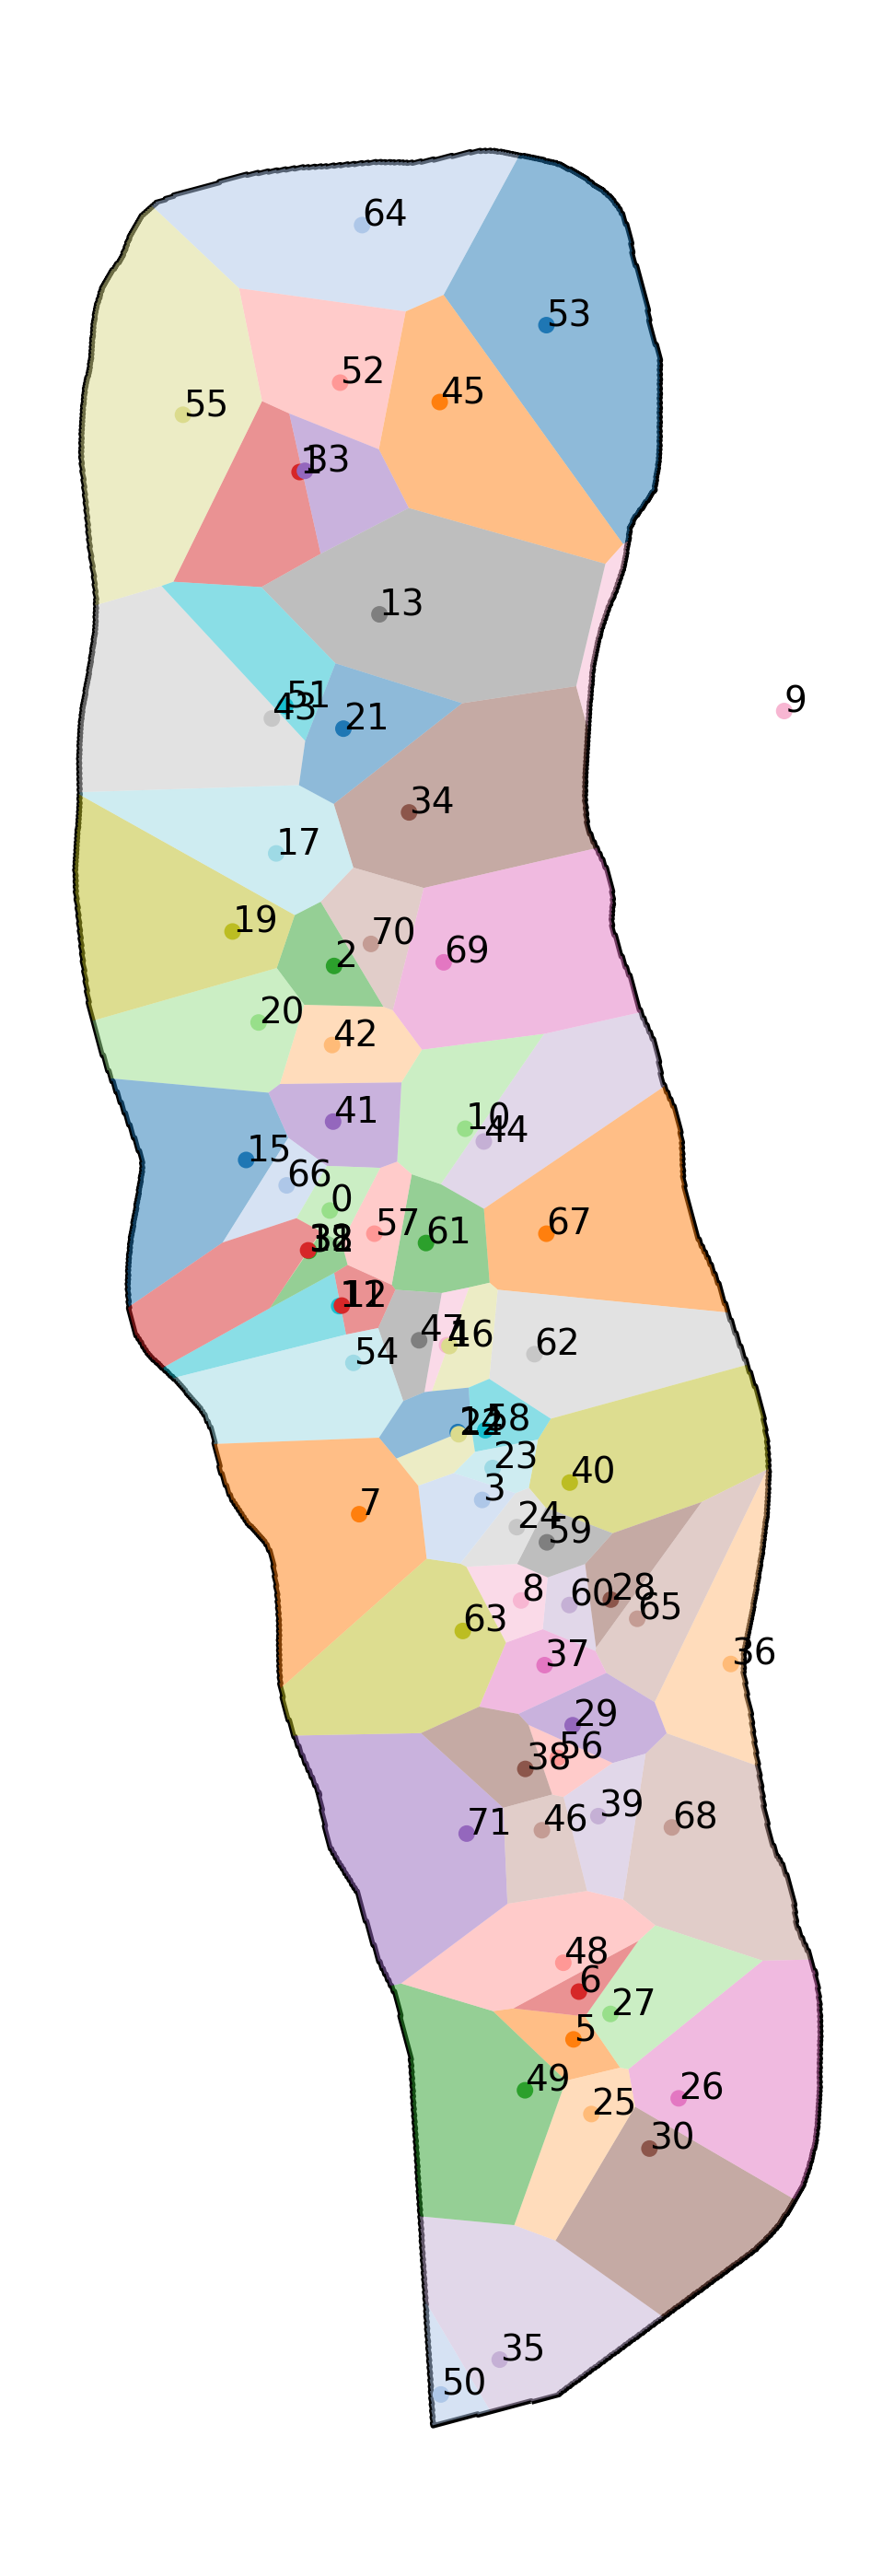

In [9]:

#print(perimeters)
fig, ax = subplot_for_map(figsize=(15, 9), dpi=400)
print("len(welltracks) = ", len(welltracks))
for i in range(len(welltracks)):
    ax.annotate(str(i), (welltracks[i][1][0], welltracks[i][2][0]), fontsize=7)
plot_voronoi_polys_with_points_in_area(ax, s, region_polys, c, region_pts)
plt.show()


In [10]:
mat_size = len(welltracks)
print('mat size is ', mat_size)
adj_mat = [np.array([-1 for i in range(mat_size)]) for j in range(mat_size)]
for i in range(mat_size - 1):
    for j in range(mat_size - 1):
        for reg1 in region_pts[i]:
            for reg2 in region_pts[j]:
                if (i == j):
                    adj_mat[reg1][reg2] = 0
                    continue
                adj_mat[reg1][reg2] = getCommonLength(np.array(boundaries[i]), np.array(boundaries[j]))
                if(adj_mat[reg1][reg2] > 0):
                    print(reg1, ' and ', reg2, ' are neibors with common length ', adj_mat[reg1][reg2])
print(adj_mat)

mat size is  72
53  and  64  are neibors with common length  6360
53  and  45  are neibors with common length  12260


C:\Users\student.STUDY\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3398: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


53  and  9  are neibors with common length  200
64  and  53  are neibors with common length  6360
64  and  45  are neibors with common length  1650
64  and  52  are neibors with common length  6718
64  and  55  are neibors with common length  4804
45  and  53  are neibors with common length  12260
45  and  64  are neibors with common length  1650
45  and  52  are neibors with common length  5602
45  and  33  are neibors with common length  2630
45  and  9  are neibors with common length  1058
45  and  13  are neibors with common length  8159
42  and  2  are neibors with common length  3164
42  and  20  are neibors with common length  3307
42  and  70  are neibors with common length  400
42  and  69  are neibors with common length  1955
42  and  10  are neibors with common length  1539
42  and  41  are neibors with common length  4853
2  and  42  are neibors with common length  3164
2  and  20  are neibors with common length  1830
2  and  70  are neibors with common length  4885
2  and 

62  and  67  are neibors with common length  9227
62  and  40  are neibors with common length  8117
62  and  16  are neibors with common length  3573
62  and  58  are neibors with common length  2930
40  and  36  are neibors with common length  66
40  and  62  are neibors with common length  8117
40  and  28  are neibors with common length  3772
40  and  65  are neibors with common length  2904
40  and  59  are neibors with common length  2865
40  and  24  are neibors with common length  1037
40  and  58  are neibors with common length  979
40  and  23  are neibors with common length  1954
16  and  67  are neibors with common length  425
16  and  61  are neibors with common length  839
16  and  4  are neibors with common length  4400
16  and  62  are neibors with common length  3573
16  and  58  are neibors with common length  892
16  and  14  are neibors with common length  1475
11  and  12  are neibors with common length  2503
11  and  54  are neibors with common length  7129
11  and

29  and  65  are neibors with common length  2253
29  and  37  are neibors with common length  3875
29  and  56  are neibors with common length  3685
29  and  39  are neibors with common length  1367
29  and  38  are neibors with common length  594
39  and  68  are neibors with common length  5891
39  and  48  are neibors with common length  1481
39  and  56  are neibors with common length  2384
39  and  29  are neibors with common length  1367
38  and  71  are neibors with common length  4435
38  and  37  are neibors with common length  1591
38  and  63  are neibors with common length  2556
38  and  56  are neibors with common length  2935
38  and  29  are neibors with common length  594
[array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   28,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  901, 1112,
          0,    0,    0,    0,    0,    0,    0,    0, 2130,    0,    0,
         

In [11]:
squares = []
from main import parse_welltracks
for i in range(len(region_polys)):
    squares.append(region_polys[i].area)

72


In [12]:
def get_dis_mat():
    dis_mat = [[0 for i in range(len(welltracks))] for i in range(len(welltracks))]
    for well1 in range(len(welltracks)):
        for well2 in range(len(welltracks)):
            x1 = welltracks[well1][1][0]
            y1 = welltracks[well1][2][0]
            x2 = welltracks[well2][1][0]
            y2 = welltracks[well2][2][0]
            dis_mat[well1][well2] = dist(x1, y1, x2, y2) / 2
    return dis_mat
dis_mat = get_dis_mat()

In [13]:
bg = 0.00848016
def zero_formula(S, H, kp, kg, bg = 0.00848016, ft = 1, fp = 1):
    return S*H*kp*kg/bg


In [14]:
mean_k_nas = [sum(k)/len(k) for k in k_nas if len(k) > 0]
mean_k_por = [sum(k)/len(k) for k in k_por if len(k) > 0]
heights = get_heights_list()

72


zero_formula =  589397238293.2645
len data =  72
[12, 5, 6, 29, 12, 8]
hist
e =  22.715725691617884
d =  139.78012420672792
integral =  0.9315017351579967


C:\Users\student.STUDY\Downloads\workshop_2022-main\vis_rigis_data.py:46: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout();


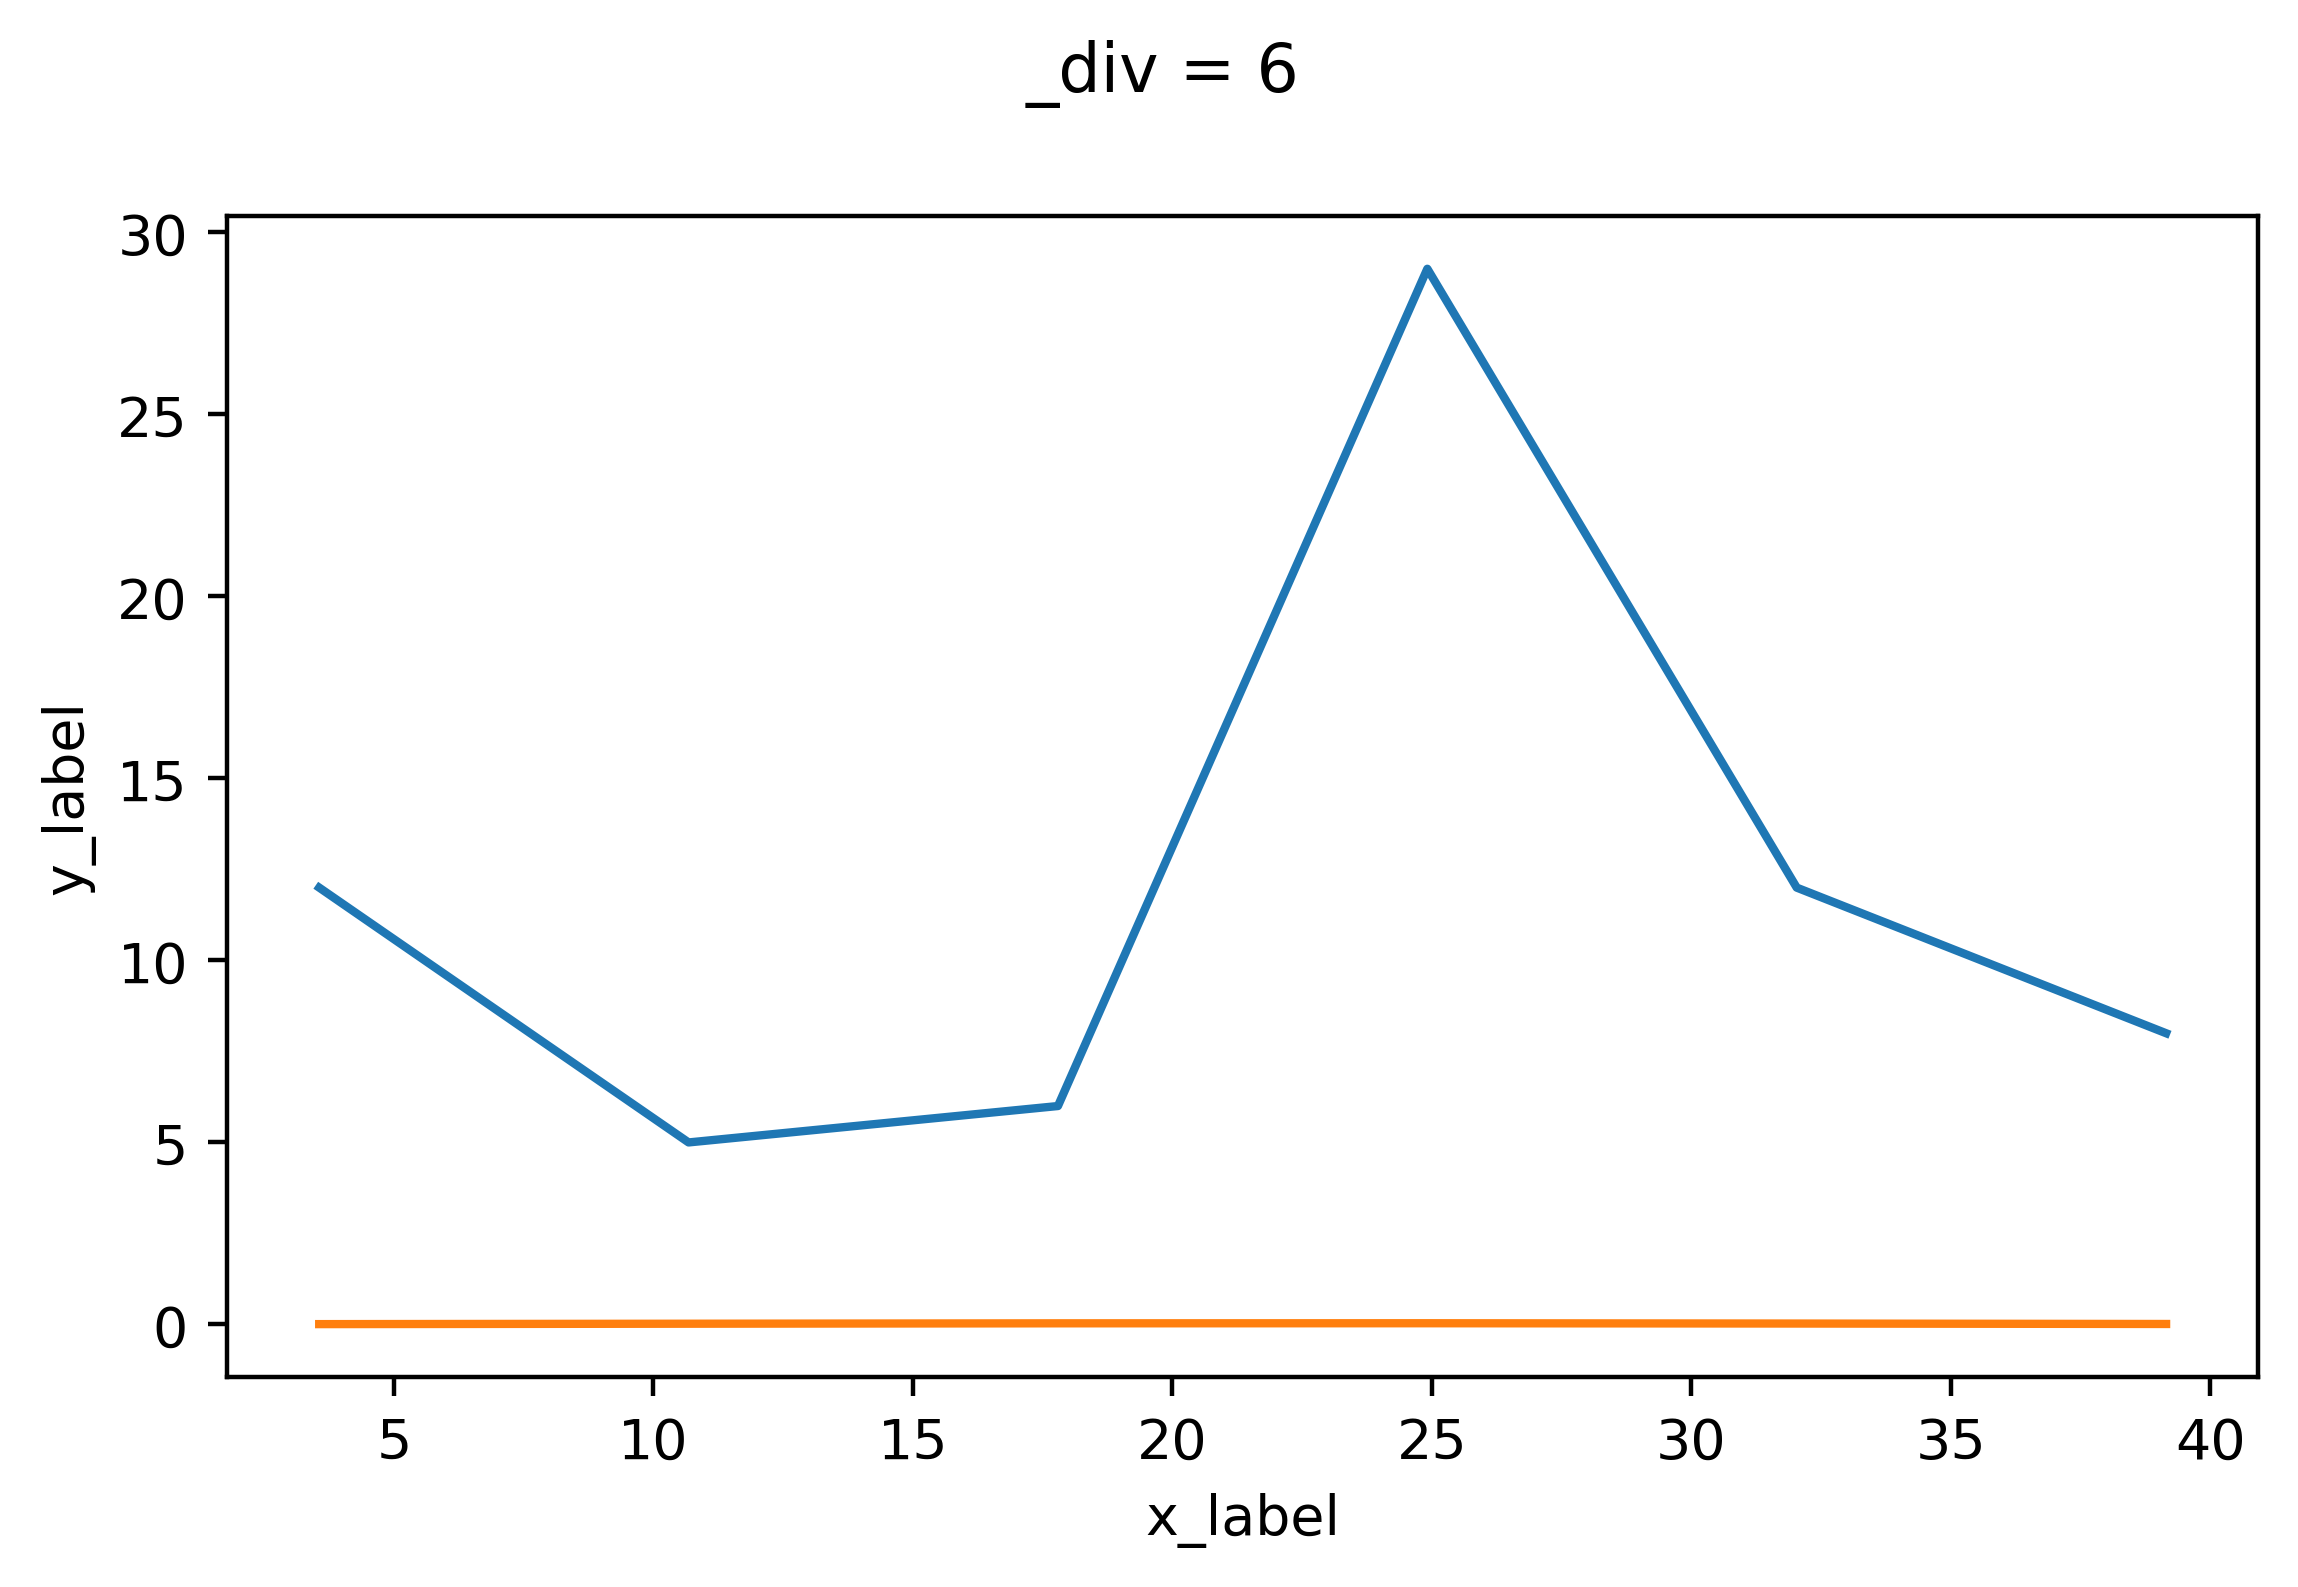

k_por med =  0.2699465555555556
k_nas med =  0.5854929999999999


In [15]:
from vis_rigis_data import visualize_data
print("zero_formula = ", zero_formula(main_area, sum(heights)/len(heights), sum(mean_k_por)/len(mean_k_por), sum(mean_k_nas)/len(mean_k_nas)))
visualize_data(heights, 6)
print("k_por med = ", mean_k_por[0])
print("k_nas med = ", mean_k_nas[0])
#plt.plot(,[])

In [16]:
len([np.mean(x) for x in k_nas])

C:\Users\student.STUDY\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\student.STUDY\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


72

In [17]:
for i in range(len(dis_mat)):
    for j in range(len(dis_mat[i])):
        if(adj_mat[i][j] == 0):
            dis_mat[i][j] = 0

In [18]:
from get_value import get_value

print(len(mean_k_nas), len(mean_k_por), len(heights), len(squares), len(adj_mat), len(perimeters))

#v1 = get_value(mean_k_nas, mean_k_por, heights, squares, adj_mat, perimeters)
#sum(v1)/bg

65 72 72 72 72 72


In [19]:
import copy
def get_value(k_gas,k_por,h,S,mat,P):
    value = []
    temp_value = []
    for i in range(len(k_gas)):
        temp_value.append(k_gas[i]*k_por[i]*h[i]/2)
        value.append(k_gas[i]*k_por[i]*h[i]/2)
    for i in range(len(k_gas)):
        for V in range(len(mat[i])):
            if mat[i][V]>0:
                value[i]+=mat[i][V]/P[i]*temp_value[V]
    value=[S[i]*x for x in value]
    return value


# In[181]:


def get_value2(k_gas,k_por,h,S,mat,P,compress = 1000000):
    '''Считаем произведение вероятностей. Каждое значение перемножается с каждым другим. Перемножаем k_por k_gas h'''
    gas_por = []
    for i in range (len(k_gas)):
        if sum(k_gas[i])!=0:
            temp = []
            for gas in k_gas[i]:
                for por in k_por[i]:
                    temp.append(gas*por)

            gas_por_h = []
            for gaspor in temp:
                for H in h[i]:
                    gas_por_h.append(gaspor*H/2)

            gas_por.append(gas_por_h)
        else:
            gas_por.append([0])
    print([len(gas) for gas in gas_por])
    adskoe_raspredelenie=[]
    for id_well in range (len(k_gas)):
        print(id_well,'/', len(k_gas))
        save = copy.deepcopy(gas_por[id_well])
        for id_p_j in range(len(mat[id_well])):
                temp = []
                if len(save)>compress:
                    #print(len(save),len(gas_por[id_p_j]),len(honey_compress(temp)))
                    save=honey_compress(save)
                if (id_p_j!= id_well and mat[id_well][id_p_j]>0):
                    for V in save:
                        for V_j in gas_por[id_p_j]:
                            temp.append(V+V_j*mat[id_well][id_p_j]/P[id_well])
                    save = copy.deepcopy(temp)
                #else:
        save = [x*S[id_well] for x in save]
        
        adskoe_raspredelenie.append(save)
    return adskoe_raspredelenie


def get_value3(k_gas,k_por,h,S,mat,dis_mat,P,compress = 1000000):
    '''Считаем произведение вероятностей. Каждое значение перемножается с каждым другим. Перемножаем k_por k_gas h'''
    gas_por = []
    for i in range (len(k_gas)):
        if sum(k_gas[i])!=0:
            temp = []
            for gas in k_gas[i]:
                for por in k_por[i]:
                    temp.append(gas*por)

            gas_por_h = []
            for gaspor in temp:
                for H in h[i]:
                    gas_por_h.append(gaspor*H/2)

            gas_por.append(gas_por_h)
        else:
            gas_por.append([0])
    print([len(gas) for gas in gas_por])
    adskoe_raspredelenie=[]
    for id_well in range (len(k_gas)):
        print(f'{id_well+1}/{len(k_gas)} is {int((id_well+1)/len(k_gas)*100)}',"%")
        save = copy.deepcopy(gas_por[id_well])
        for id_p_j in range(len(mat[id_well])):
                temp = []
                if len(save)>compress:
                    save=honey_compress(save)
                if (id_p_j!= id_well and mat[id_well][id_p_j]>0):
                    nu_norm = sum([x/y for (x,y) in zip(mat[id_well],dis_mat[id_well]) if y != 0])
                    if(nu_norm == 0):
                        nu_norm = 1
                    for V in save:
                        for V_j in gas_por[id_p_j]:
                            
                            temp.append(V+V_j*mat[id_well][id_p_j]/dis_mat[id_well][id_p_j]/nu_norm)
                    save = copy.deepcopy(temp)
        summat = sum(mat[id_well])
        summatdis = sum(dis_mat[id_well])
        coeff =(2*P[id_well]*summatdis)/ \
        (P[id_well]*summatdis+sum([x*y for x,y in zip(mat[id_well],dis_mat[id_well])]))
        save = [x*S[id_well] for x in save]
        #save = [x*coeff for x in save]
        adskoe_raspredelenie.append(save)
    return adskoe_raspredelenie

def honey_compress(value_list, razmer_zhim=1000):
    value= len(value_list)
    temp_div= 2
    min_div = 1
    while(value>razmer_zhim):
        if (value%temp_div==0):
            min_div*=temp_div
            value= value//temp_div
        else:
            temp_div+=1
    value_list.sort();
    new_value_list=[sum(value_list[(x)*min_div:(x+1)*min_div])/min_div for x in range(value)]
    return new_value_list


In [20]:
v3 =get_value3(k_nas, k_por, [[h] for h in heights], squares, adj_mat,dis_mat, perimeters, 10000)

[63, 1, 1, 70, 154, 120, 440, 150, 440, 60, 285, 76, 120, 255, 48, 308, 1, 288, 90, 40, 60, 195, 117, 126, 176, 90, 270, 210, 195, 105, 80, 320, 1, 575, 484, 304, 420, 272, 238, 320, 525, 528, 115, 252, 462, 483, 187, 160, 88, 224, 96, 168, 1, 255, 46, 484, 81, 169, 225, 270, 552, 266, 130, 672, 1, 252, 1, 234, 65, 144, 11, 675]
1/72 is 1 %
2/72 is 2 %
3/72 is 4 %
4/72 is 5 %
5/72 is 6 %
6/72 is 8 %
7/72 is 9 %
8/72 is 11 %
9/72 is 12 %
10/72 is 13 %
11/72 is 15 %
12/72 is 16 %
13/72 is 18 %
14/72 is 19 %
15/72 is 20 %
16/72 is 22 %
17/72 is 23 %
18/72 is 25 %
19/72 is 26 %
20/72 is 27 %
21/72 is 29 %
22/72 is 30 %
23/72 is 31 %
24/72 is 33 %
25/72 is 34 %
26/72 is 36 %
27/72 is 37 %
28/72 is 38 %
29/72 is 40 %
30/72 is 41 %
31/72 is 43 %
32/72 is 44 %
33/72 is 45 %
34/72 is 47 %
35/72 is 48 %
36/72 is 50 %
37/72 is 51 %
38/72 is 52 %
39/72 is 54 %
40/72 is 55 %
41/72 is 56 %
42/72 is 58 %
43/72 is 59 %
44/72 is 61 %
45/72 is 62 %
46/72 is 63 %
47/72 is 65 %
48/72 is 66 %
49/72 is 68 %

In [21]:
#v2 =get_value2(k_nas, k_por, [[h] for h in heights], squares, adj_mat, perimeters, 10000)


In [22]:
from collections import Counter

In [23]:
def itog_rasp(all_value,honey = 50000):
    first_well = all_value[0]
    for id_value in range(1,len(all_value)):
        temp = []
        if len(first_well)>honey:
            first_well=honey_compress(first_well)
        if len(all_value[id_value])>honey:
            all_value[id_value]=honey_compress(all_value[id_value])
        print(id_value+1,'|',len(all_value))
        for first in first_well:
            for second in all_value[id_value]:
                temp.append(first+second)
        first_well= copy.deepcopy(temp)
        
    return first_well

In [24]:
v_itog = itog_rasp(v3)

2 | 72
3 | 72
4 | 72
5 | 72
6 | 72
7 | 72
8 | 72
9 | 72
10 | 72
11 | 72
12 | 72
13 | 72
14 | 72
15 | 72
16 | 72
17 | 72
18 | 72
19 | 72
20 | 72
21 | 72
22 | 72
23 | 72
24 | 72
25 | 72
26 | 72
27 | 72
28 | 72
29 | 72
30 | 72
31 | 72
32 | 72
33 | 72
34 | 72
35 | 72
36 | 72
37 | 72
38 | 72
39 | 72
40 | 72
41 | 72
42 | 72
43 | 72
44 | 72
45 | 72
46 | 72
47 | 72
48 | 72
49 | 72
50 | 72
51 | 72
52 | 72
53 | 72
54 | 72
55 | 72
56 | 72
57 | 72
58 | 72
59 | 72
60 | 72
61 | 72
62 | 72
63 | 72
64 | 72
65 | 72
66 | 72
67 | 72
68 | 72
69 | 72
70 | 72
71 | 72
72 | 72


In [25]:
len(v_itog)

98923

In [26]:
from vis_rigis_data import expection, dispersion, normal_
def visualize_data(data = [], _div = 5, x_label = 'x_label', y_label = 'y_label'):
    data_count = [0 for x in range(_div)]
    print("len data = ", len(data))
    max_data = max(data)+0.1
    min_data = min(data)
    delta = max_data - min_data

    step = delta/_div
    steps = [min_data+step/2]
    for i in range(1,_div):
        steps.append(steps[-1]+step)
    for k in data:
        index = math.floor((k - min_data)/step)
        if index >= len(data_count):
            index -= 1
        data_count[math.floor(index)]+=1
    print(data_count)

    fig, ax = plt.subplots(layout='constrained', dpi = 400)
    fig.suptitle('_div = '+str(_div))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    fig.tight_layout();
    print("hist")
    ax.plot(steps, data_count)
    e = expection(data)
    print('e = ', e)
    d = dispersion(data, e)
    print('d = ', d)
    x = steps
    ax.plot(x, normal_(x, e, d), label = 'Нормальное распределение')
    print("integral = ", sum(step * normal_(x,e,d)))

    #ax.plot(x, x**2, 'test')
    plt.show()


len data =  98923
[176, 228, 460, 841, 1436, 2297, 3445, 4832, 6340, 7803, 8996, 9743, 9909, 9453, 8488, 7150, 5660, 4213, 2941, 1923, 1188, 692, 383, 175, 151]
hist
e =  4765789576.069716
d =  6028191698907987.0
integral =  0.9984972696574018


C:\Users\student.STUDY\AppData\Local\Temp\ipykernel_7280\2883202006.py:24: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout();


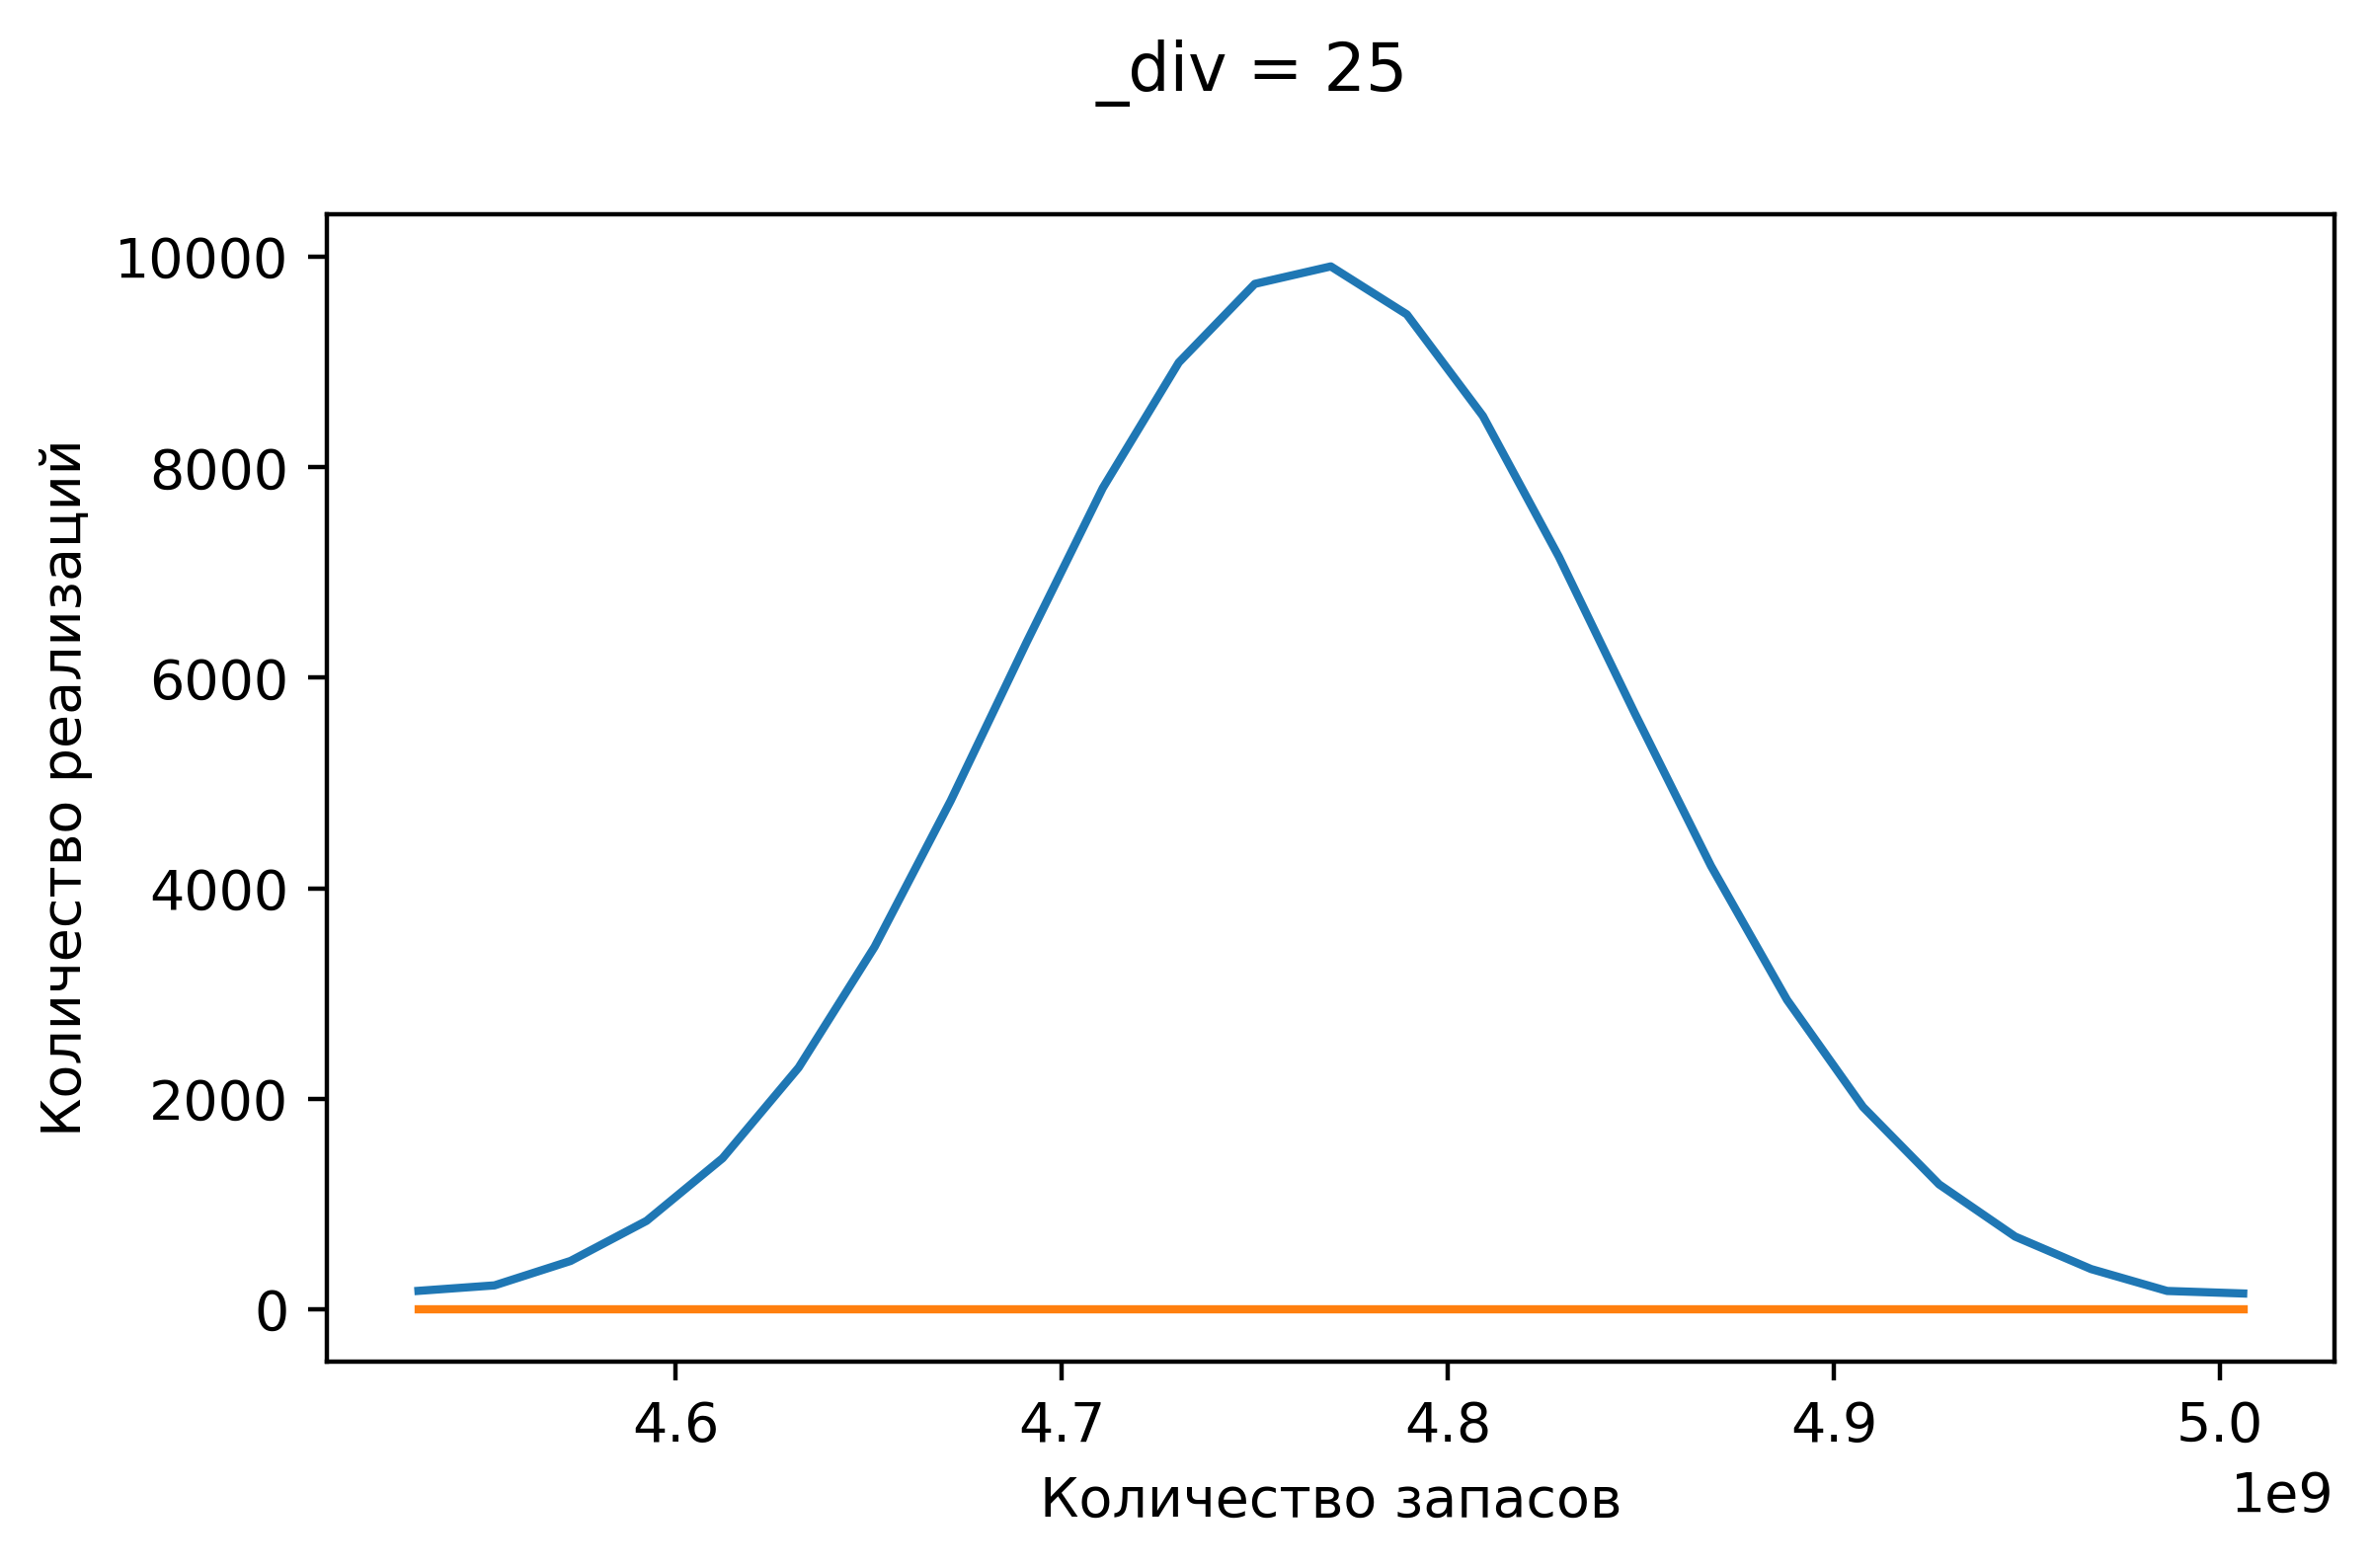

In [27]:
visualize_data(v_itog, 25, "Количество запасов", "Количество реализаций")

len data =  72
[5, 16, 13, 7, 5, 7, 9, 7, 1, 2]
hist
e =  19833.745666281204
d =  79608883.577716
integral =  0.9385014523778525


C:\Users\student.STUDY\AppData\Local\Temp\ipykernel_7280\2883202006.py:24: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout();


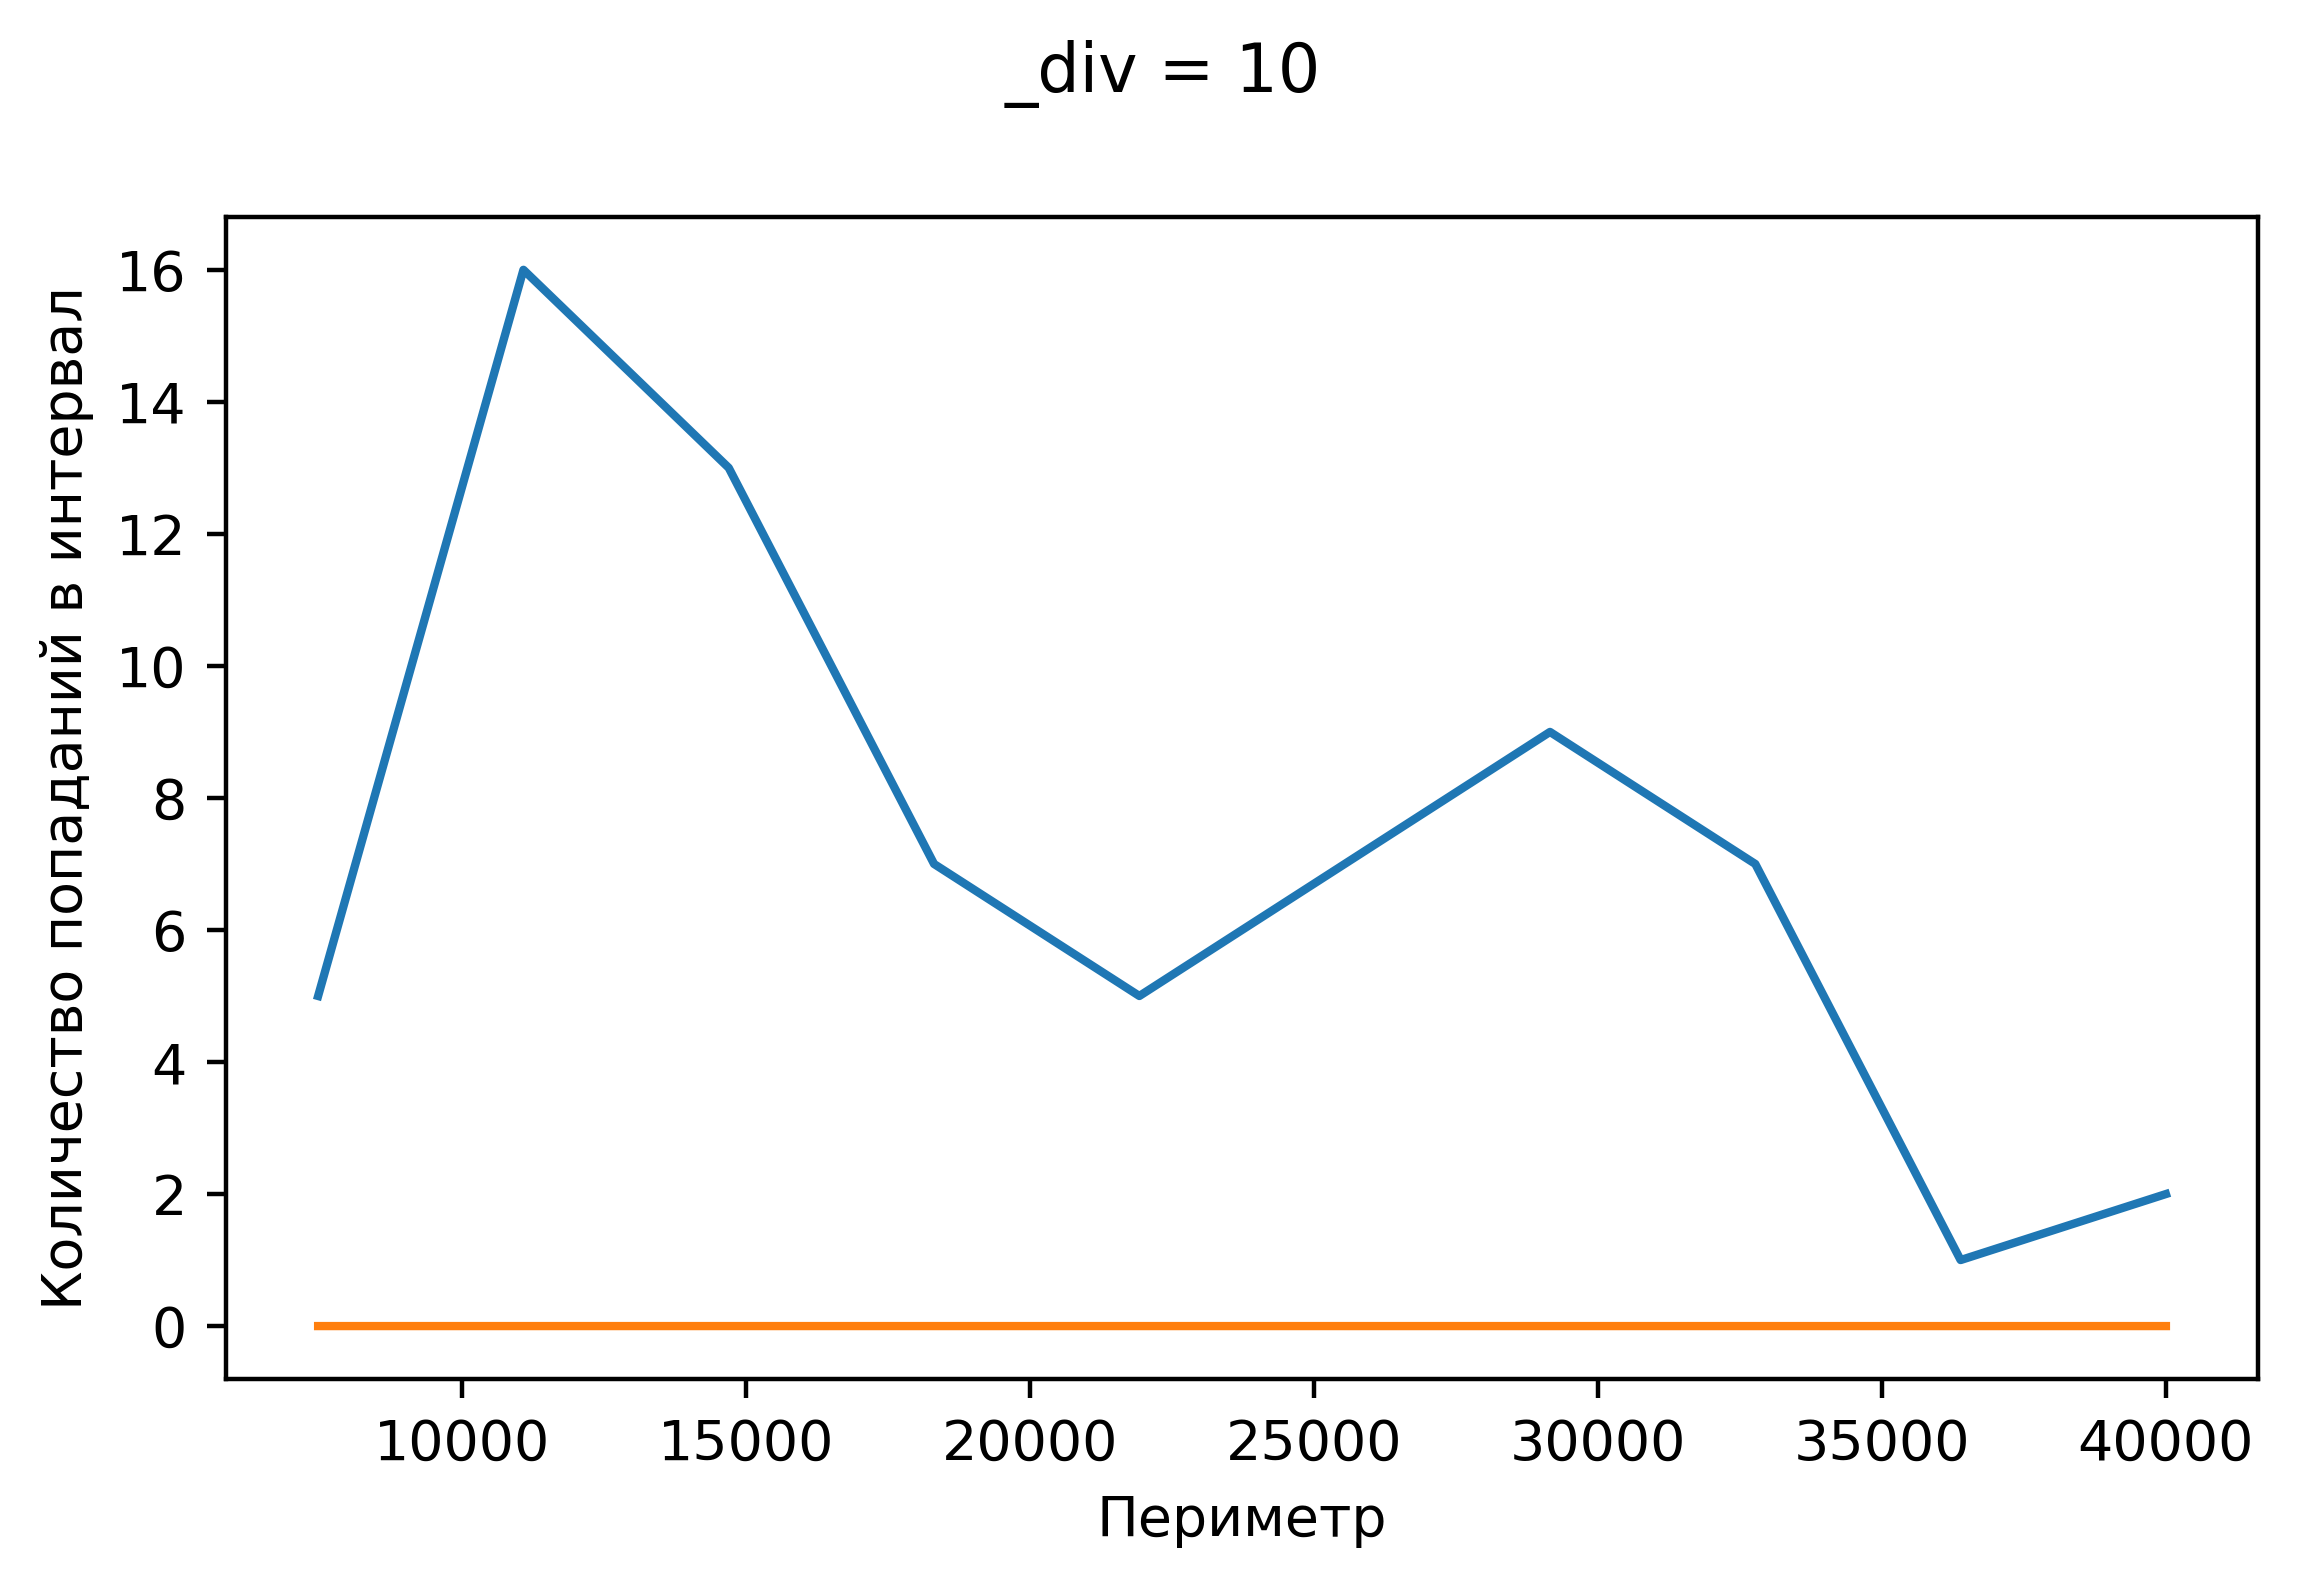

In [28]:
k_n = []
for k in k_por:
    k_n += k
visualize_data(perimeters, 10, "Периметр", "Количество попаданий в интервал")

In [30]:
sum(v_itog)/len(v_itog)/bg

561992884104.7476